# About this practical session
## Importation risk

If a disease is detected in county A. Which are the countries at highest risk of importing a case from county A? 
The risk of importation from a county A to a county B is can be defined as the probability of traveling from A to B, conditional on traveling.  
In other words: let us assume that an infected person is about to travel out of the country. Where will they go? Importation risk to country B is the probability that they will go to B.  

So we can turn the definition of risk into a mathematical law:   
$$C_{ab} = \frac{W_{ab}}{W_a}$$

where the sum of is computed over all countries except the origin country , to obtain the probabily of traveling from to conditionally to traveling. Here, is the risk matrix: is the probability that a case traveling out of country a, ends up in country b. As you can see, this formula is extremely simple and relies on mobility. Nowhere we needed epidemiological data!

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import os
import geopandas as gpd
import statsmodels.api as sm

In [2]:
# If you encounter an ImportError try installing packages using the following command:
# !pip install geopandas

In [3]:
# A function for formatting dates in plots
def dateFormat(ax):
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator, show_offset=False)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# Read data

In [22]:
# Load the GeoJSON file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
geoData = geoData.to_crs("ESRI:102003")
geoData = geoData.set_index('id')

hideStates = ['02', '69','44' ,'66' ,'15' ,'60' ,'78' ,'72']
geoData = geoData.query("STATE not in @hideStates")

In [23]:
# Read county to county csv file
# (if executed on Google Colab change the path in 'https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/mobilityflows/mobilityFlowsCounty.csv.xz')
 
c2c = pd.read_csv('./mobilityflows/mobilityFlowsCounty.csv.xz', dtype={"county_o": str, "county_d": str})
c2c['date'] = pd.to_datetime(c2c['date']) # transform column in datetime
c2c['county_o'] = c2c['county_o'].astype(str).apply(lambda a: a.zfill(5)) #Transform to strings and containing 5 characters
c2c['county_d'] = c2c['county_d'].astype(str).apply(lambda a: a.zfill(5)) #Transform to strings and containing 5 characters

In [24]:
# Display 10 random rows from the dataset
c2c.sample(2)

,county_o,county_d,pop_flows,date
17517795,50007,08037,36.0,2020-03-03
20393871,39117,40125,10.0,2020-03-07


In [18]:
# Should we remove the travel inside the same couunty??
#c2c = c2c.query('county_o != county_d')

# Create $C_{ab}$

In [ ]:
# Filter mobility for a certain date
df = ... 

# Compute the denominator W_a
Wa = ...

# Add the total outgoing flow (W_a) as a new column in the dataframe
# Hint: inside the map() function, you can use a Series or DataFrame where the index holds the keys and the values are what you want to assign
...

# Now compute C_ab as a new column in the dataframe
...

In [25]:
# ========== SOLUTION ==========
# Filter mobility for a certain date
df = c2c.query('date == "2020-03-02"').copy()

# Compute the denominator W_a
Wa = df.groupby('county_o')['pop_flows'].sum()

# Add the total outgoing flow (W_a) as a new column in the dataframe
# Hint: inside the map() function, you can use a Series or DataFrame where the index holds the keys and the values are what you want to assign
df['Wa'] = df['county_o'].map(Wa)

# Now compute C_ab as a new column in the dataframe
df['C'] = df['pop_flows']/df['Wa']

df.head(2)

,county_o,county_d,pop_flows,date,Wa,C
17653568,01001,01001,90187.0,2020-03-02,142635.0,0.632292
17653569,01001,01003,63.0,2020-03-02,142635.0,0.000442


# Select a source county and plot on a map the risk 

In [26]:
# Select the C_ab values for a specfic location and add the values to geoData 
source = '36061'  # (New York City, New York)
dfSource = df.query('county_o == @source')

# Merge geoData with dfSource
geoDataC = geoData.merge(dfSource, left_index=True, right_on='county_d')
geoDataC.head(2)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,county_o,county_d,pop_flows,date,Wa,C
17867076,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((1003933.242 -460749.207, 1010796.008...",36061,01017,26.0,2020-03-02,3536275.0,0.000007
17867081,0500000US01079,01,079,Lawrence,County,690.678,"POLYGON ((807251.107 -277301.493, 808203.510 -...",36061,01079,79.0,2020-03-02,3536275.0,0.000022


<Axes: >

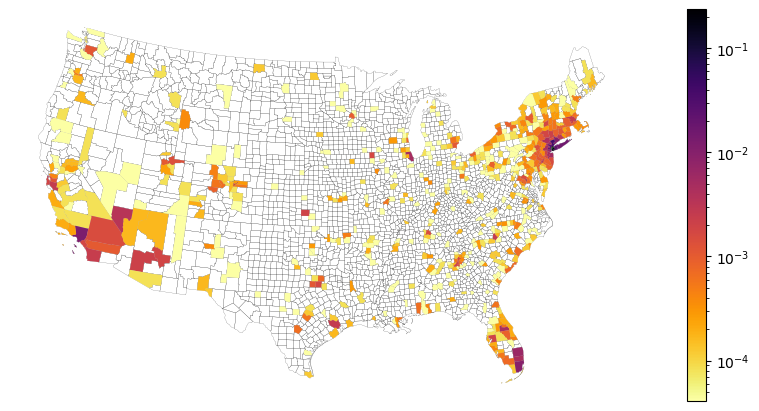

In [21]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=1, layout='constrained')
colorNorm = mpl.colors.LogNorm(vmin=geoDataC['C'].min(), vmax=geoDataC['C'].max())
ax.axis('off')

# Plot the whole map only borders
geoData.plot(facecolor='None', ax=ax, linewidth=0.1)

# Plot the destination color based on risk C.
geoDataC.plot(column='C', cmap='inferno_r', ax=ax, linewidth=0, vmax=0.008, legend=True, norm=colorNorm)

# Plot the source in green
geoData.loc[[source]].plot(facecolor='green', ax=ax, linewidth=0)

In [ ]:
# 1) Where is the most/less dangerous county?
# Think about what "most dangerous" could mean: 
# Is it the county with the most connections? The highest total incoming or outgoing flow (e.g., sum of W_ab)? 
# Explore different definitions and plot
...

In [ ]:
# ===== SOLUTION =====
# 1) Where is the most/less dangerous county?
# Think about what "most dangerous" could mean: 
# Is it the county with the most connections? The highest total incoming or outgoing flow (e.g., sum of W_ab)? 
# Explore different definitions and plot

# Dangerous as sum of W_ab
df.query('county_o != county_d').groupby('county_o')['C'].sum().sort_values().tail(10)

# Dangerous of #connections
df.query('county_o != county_d').groupby('county_o')['C'].count().sort_values().tail(10)

In [ ]:
# 2) Test other sources. Big cities vs more pheripheral counties
...

In [ ]:
# 3) Test different dates, before after lockdown
...

In [ ]:
# Plot what you find
source = '...'

dfSource = df.query('county_o == @source')
geoDataC = geoData.merge(dfSource, left_index=True, right_on='county_d')

fig, ax = plt.subplots(figsize=(12, 4), ncols=1, layout='constrained')
ax.axis('off')

# Plot the whole map only borders
geoData.plot(facecolor='None', ax=ax, linewidth=0.1)

# Plot the destination color based on risk C.
geoDataC.plot(column='C', cmap='inferno_r', ax=ax, linewidth=0, vmax=0.008, legend=True, norm=colorNorm)
geoData.loc[[source]].plot(facecolor='green', ax=ax, linewidth=0)

# EXTRA: Compare two dates

In [39]:
def addColumnC(df):
    # Compute the denominator W_a
    Wa = df.groupby('county_o')['pop_flows'].sum()
    Wa.name = 'Wa'
    
    # Add the denominator W_a to the df dataframe
    df = df.merge(Wa, left_on='county_o', right_index=True)

    # Now compute C_ab
    df['C'] = df['pop_flows']/df['Wa']
    return df

In [40]:
# Select a certain date from the c2c DataFrame
source = '36061'

dfDate1 = c2c.query('date == "2020-03-02" and county_o == @source')
dfDate2 = c2c.query('date == "2020-03-28" and county_o == @source')

dfDate1 = addColumnC(dfDate1)
dfDate2 = addColumnC(dfDate2)

In [41]:
# Merge geoData with dfSource
geoDataC1 = geoData.merge(dfDate1, left_index=True, right_on='county_d')
geoDataC2 = geoData.merge(dfDate2, left_index=True, right_on='county_d')

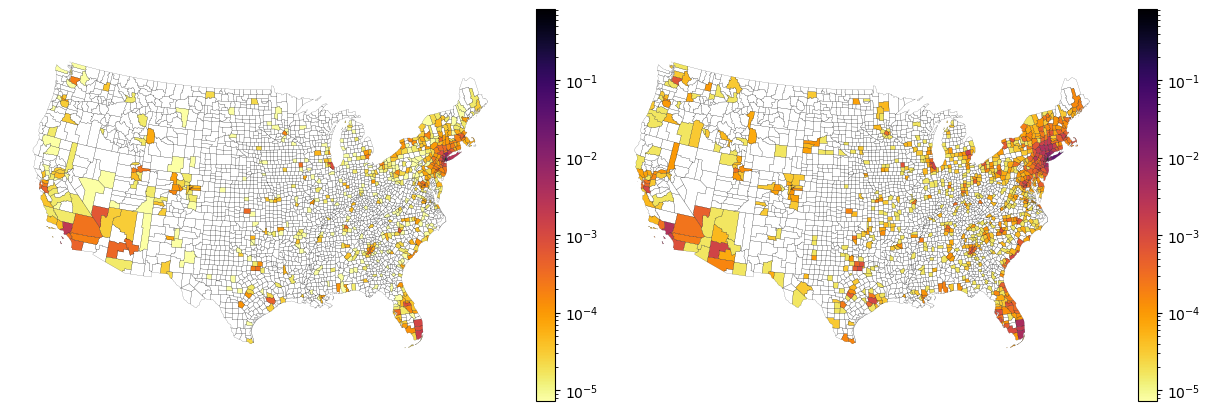

In [42]:
fig, axs = plt.subplots(figsize=(12, 4), ncols=2, layout='constrained')
colorNorm = mpl.colors.LogNorm(vmin=min(geoDataC1['C'].min(),geoDataC1['C'].min()), vmax=max(geoDataC1['C'].max(),geoDataC1['C'].max()))

# Plot the destination color based on risk C.
geoDataC1.plot(column='C', cmap='inferno_r', ax=axs[0], linewidth=0, legend=True, norm=colorNorm)
geoDataC2.plot(column='C', cmap='inferno_r', ax=axs[1], linewidth=0, legend=True, norm=colorNorm)

for ax in axs: 
    ax.axis('off')
    geoData.plot(facecolor='None', ax=ax, linewidth=0.1)
    geoData.loc[[source]].plot(facecolor='green', ax=ax, linewidth=0)

In [ ]:
# why do they look similar?